# EXERCISE 2  - ML - Grundverfahren

## 1.) Multiclass Classification

The Iris Dataset is a very classical machine learning and statistics benchmark for classification, developed in the 1930's. The goal is to classify 3 types of flowers (more specifically, 3 types of flowers form the Iris species) based on 4 features: petal length, petal width, sepal length and sepal width.

As we have $K=3$ different types of flowers we are dealing with a multi-class classification problem and need to extend our sigmoid-based classifier from before the previous exercise / lecture notebook. 

We will reuse our "minimize" and "affine feature" functions. Those are exactly as before. The affine feautres are sufficient here. 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestRegressor
from typing import Callable, Tuple

warnings.filterwarnings('ignore')

def minimize(f: Callable , df: Callable, x0: np.ndarray, lr: float, num_iters: int) -> \
        Tuple[np.ndarray, float, np.ndarray, np.ndarray]:
    """
    :param f: objective function
    :param df: gradient of objective function
    :param x0: start point, shape [dimension]
    :param lr: learning rate
    :param num_iters: maximum number of iterations
    :return argmin, min, values of x for all interations, value of f(x) for all iterations
    """
    # initialize
    x = np.zeros([num_iters + 1] + list(x0.shape))
    f_x = np.zeros(num_iters + 1)
    x[0] = x0
    f_x[0] = f(x0)
    for i in range(num_iters):
        # update using gradient descent rule
        grad = df(x[i])
        x[i + 1] = x[i] - lr * grad
        f_x[i + 1] = f(x[i + 1])
    return x[i+1], f_x[i+1], x[:i+1], f_x[:i+1] # logging info for visualization


def affine_features(x: np.ndarray) -> np.ndarray:
    """
    implements affine feature function
    :param x: inputs
    :return inputs with additional bias dimension
    """
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)

### Load and Prepare Data
In the original dataset the different types of flowers are labeled with $0, 1$ and $2$. The output of our classifier will be a vector with $K=3$ entries, $\begin{pmatrix}p(c=0) & p(c=1) & p(c=2) \end{pmatrix}$, i.e. the probability for each class that a given sample is an instance of that class. Thus we need to represent the labels in a different form, a so called one-hot encoding. This is  vector of the length of number of classes, in this case 3, with zeros everywhere except for the entry corresponding to the class number, which is one. For the train and test data we know to which class it belongs, so the probability for that class is one and the probability for all other classes zero.

In [2]:
data = np.load("iris_data.npz")
train_samples = data["train_features"]
train_labels = data["train_labels"]
test_samples = data["test_features"]
test_labels = data["test_labels"]

train_features = affine_features(train_samples)
test_features = affine_features(test_samples)

def generate_one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """
    :param y: vector containing classes as numbers, shape: [N]
    :param num_classes: number of classes
    :return a matrix containing the labels in an one-hot encoding, shape: [N x K]
    """
    y_oh = np.zeros([y.shape[0], num_classes])

    # can be done more efficiently using numpy with
    # y_oh[np.arange(y.size), y] = 1.0
    # but I decided to used the for loop for clarity

    for i in range(y.shape[0]):
        y_oh[i, y[i]] = 1.0

    return y_oh


oh_train_labels = generate_one_hot_encoding(train_labels, 3)
oh_test_labels = generate_one_hot_encoding(test_labels, 3)

## Optimization using Gradient Descent

The multi-class generalization of the sigmoid is the softmax function. It takes an vector of length $K$ and outputs another vector of length $K$ where the $k-th$ entry is given by
$$ \textrm{softmax}(\boldsymbol{x})_k = \dfrac{\exp(x_k)}{\sum_{j=1}^K \exp(x_j)}.$$
The output vector always sumes to $1$, thus can be interpreted as parameters of a categorical distribution.


In [3]:
def softmax(x: np.ndarray) -> np.ndarray:
    """softmax function
    :param x: inputs, shape: [N x K]
    :return softmax(x), shape [N x K]
    """
    a = np.max(x, axis=-1, keepdims=True)
    log_normalizer = a + np.log(np.sum(np.exp(x - a), axis=-1, keepdims=True))
    return np.exp(x - log_normalizer)

**Practical Aspect:** In the above implementation of the softmax we stayed in the log-domain until the very last command.
We also used the log-sum-exp-trick (https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations).
Staying in the log domain and applying the log-sum-exp-trick whenever possible is a simple way to make the implementation
more numerically robust. It does not change anything with regards to the underlying theory.

We also need to extend our loss function. Instead of the likelihood of a bernoulli, we now maximize the likelihood of a categorical distribution which, for a single sample $\boldsymbol{x}_i$ is given by
$$  \sum_k^K h_{i, k} \log(p_{i,k}) $$
where $h_i$ denotes the true label and $p_i$ the one predicted by the classifier (both in one-hot representation).
As we are again minimizing we instead implement the negated likelihood of a categorical distribution.

In [4]:
def categorical_nll(predictions: np.ndarray, labels: np.ndarray, epsilon: float = 1e-12) -> np.ndarray:
    """
    cross entropy loss function
    :param predictions: class labels predicted by the classifier, shape: [N x K]
    :param labels: true class labels, shape: [N x K]
    :param epsilon: small offset to avoid numerical instabilities (i.e log(0))
    :return negative log-likelihood of the labels given the predictions, shape: [N]
    """
    return - np.sum(labels * np.log(predictions + epsilon), -1) 


Again we work with the mean over all samples instead of the sum thus, the full loss if given by.

\begin{align} Loss_{cat\_nll} &= - \sum_k^K h_{i, k} \log(p_{i,k}) = - \dfrac{1}{N} \sum_i^N  \sum_k^K h_{i, k} \log(\textrm{softmax}(\boldsymbol{w}^T \phi(\boldsymbol{x}_i))_k) \\ &
= - \dfrac{1}{N} \sum_i^N \left(\sum_k^K h_{i,k}\left(\boldsymbol{w}^T_k\phi(\boldsymbol{x}_i) - \log \sum_j^K \exp(\boldsymbol{w}_j^T \phi(\boldsymbol{x}_i))\right)\right)
\end{align}

### 1.1) Derivation (4 Points)
Derive the gradient of the loss function w.r.t. $w$, i.e., $\dfrac{\partial Loss_{cat\_nll}}{\partial \boldsymbol{w}}$

**Hint 1:** Follow the steps in the derivation of the gradient of the loss for the binary classification in the lecture

**Hint 2:** Derive the gradient not for the whole matrix $w$ but only for the vector $w_k$, i.e., the weights
corresponding to class $k$, i.e., $\dfrac{\partial Loss_{cat\_nll}}{\partial \boldsymbol{w}_k}$. The gradients for the individual
$w_k$ can be "stacked" to obtain the full gradient.



**Proof**
$$
\begin{aligned}
\frac{\partial \operatorname{loss}_{i}}{\partial \boldsymbol{w}_{k}} &= - \dfrac{1}{N} \sum_i^N \frac{\partial}{\partial \boldsymbol{w}_{k}}\left(\sum_{k=1}^{K} \boldsymbol{h}_{i, k} \boldsymbol{w}_{k}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)-\log \left(\sum_{j=1}^{K} \exp \left(\boldsymbol{w}_{j}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right)\right)\right) \\
&=- \dfrac{1}{N} \sum_i^N\boldsymbol{h}_{i, k} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)-\frac{\partial}{\partial \boldsymbol{w}_{k}} \log \left(\sum_{j=1}^{K} \exp \left(\boldsymbol{w}_{j}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right)\right) \\
&=- \dfrac{1}{N} \sum_i^N\boldsymbol{h}_{i, k} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)-\frac{1}{\sum_{j=1}^{K} \exp \left(\boldsymbol{w}_{j}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right)} \exp \left(\boldsymbol{w}_{k}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right) \phi\left(\boldsymbol{x}_{i}\right) \\
&=- \dfrac{1}{N} \sum_i^N \left(\boldsymbol{h}_{i, k}-\underbrace{\frac{\exp \left(\boldsymbol{w}_{k}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right)}{\sum_{j=1}^{K} \exp \left(\boldsymbol{w}_{j}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right)}}_{\text{softmax}}\right) \underbrace{\boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)}_{\text {feature vector }} \\
\end{aligned}
$$

### 1.2) Implementation (3 Points)
Fill in the function skeletons below so that they implement the loss and its gradient.

**Hint:** The optimizer works with vectors only. So the function get the weights as vecotrs in the flat_weights parameter.
Make sure you reshape them appropriately before using them for the computations. For the gradients make sure to return
again a vector by flattening the result

In [5]:
# objective
def objective_cat(flat_weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> float:
    """
    :param flat_weights: weights of the classifier (as flattened vector), shape: [feature_dim * K]
    :param features: samples to evaluate objective on, shape: [N x feature_dim]
    :param labels: labels corresponding to samples, shape: [N]
    :return cross entropy loss of the classifier given the samples 
    """
    num_features = features.shape[-1]
    num_classes = labels.shape[-1]
    weights = np.reshape(flat_weights, [num_features, num_classes])
    
    # as per given formula. Be aware sign is already included in categorial_nll.
    loss = categorical_nll(softmax(features @ weights), labels)
    return 1.0 / loss.shape[0] * loss.sum()


# derivative
def d_objective_cat(flat_weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    :param flat_weights: weights of the classifier (as flattened vector), shape: [feature_dim * K]
    :param features: samples to evaluate objective on, shape: [N x feature_dim]
    :param labels: labels corresponding to samples, shape: [N]
    :return gradient of cross entropy loss of the classifier given the samples, shape: [feature_dim * K]
    """
    feature_dim = features.shape[-1]
    num_classes = labels.shape[-1]
    weights = np.reshape(flat_weights, [feature_dim, num_classes])
    
    # derivation as derived above
    derivative = - 1.0 / features.shape[0] * features.T @ (labels - softmax(features @ weights))

    # flatten gradient a required
    return np.reshape(derivative, -1)


Finally, we can tie everything together again. Both train and test accuracy should be at least 0.9:

Final Loss: 0.35996997155270793
Train Accuracy: 0.9583333333333334 Test Accuracy: 1.0


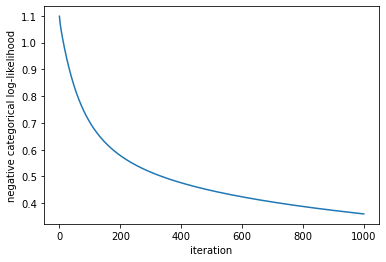

In [6]:

# optimization

w0_flat = np.zeros(5 * 3) # 4 features + bias, 3 classes
w_opt_flat, loss_opt, x_history, f_x_history = \
   minimize(lambda w: objective_cat(w, train_features, oh_train_labels),
            lambda w: d_objective_cat(w, train_features, oh_train_labels),
            w0_flat, 1e-2, 1000)

w_opt = np.reshape(w_opt_flat, [5, 3])

# plotting and evaluation
print("Final Loss:", loss_opt)
plt.figure()
plt.plot(f_x_history)
plt.xlabel("iteration")
plt.ylabel("negative categorical log-likelihood")

train_pred = softmax(train_features @ w_opt)
train_acc = np.count_nonzero(np.argmax(train_pred, axis=-1) == np.argmax(oh_train_labels, axis=-1))
train_acc /= train_labels.shape[0]
test_pred = softmax(test_features @ w_opt)
test_acc = np.count_nonzero(np.argmax(test_pred, axis=-1) == np.argmax(oh_test_labels, axis=-1))
test_acc /= test_labels.shape[0]
print("Train Accuracy:", train_acc, "Test Accuracy:", test_acc)

## 2.) k-NN (3 Points)

Here we implement a simple k-NN appraoch. As we want to use it for classification now and later for regression we choose a modular appraoch and first implement a function that returns the $k$ nearest values and corresponding target to a given query point. We than also implement a function doing a majority vote for classification, given the k nearest targets. Note that we use the "real" labels, not the one-hot encoding for the k-NN classifier. 

In [7]:
def get_k_nearest(k: int, query_point: np.ndarray, x_data: np.ndarray, y_data: np.ndarray) \
    -> Tuple[np.ndarray, np.ndarray]:                                                                                        
    """
    :param k: number of nearest neigbours to return 
    :param query_point: point to evaluate, shape [dimension]
    :param x_data: x values of the data [N x input_dimension]
    :param y_data: y values of the data [N x target_dimension]
    :return k-nearest x values [k x input_dimension], k-nearest y values [k x target_dimension]
    """

    # 1. get N count of x_data
    x_rows = np.shape(x_data)[0]
    
    # 2. calculate the Eucleadian distance between query_point x_data and y_data
    eucl_dis_x = np.linalg.norm(x_data - query_point, axis=1)

    # 3. return k-nearest points, not fully sorted for performance reasons
    dis_part_sorted = np.argpartition(eucl_dis_x, k)

    # 4. cut back to required dimensions
    return x_data[dis_part_sorted][:k], y_data[dis_part_sorted][:k]
    
def majority_vote(y: np.ndarray) -> int:
    """
    :param y: k nearest targets [K]
    :return the number x which occours most often in y. 
    """
    # find most frequent element
    return np.argmax(np.bincount(y))



We run the classifier and measure the accuracy. For $k=5$ it should be $1.0$.

In [8]:

k = 5

predictions = np.zeros(test_features.shape[0])
for i in range(test_features.shape[0]):
    _, nearest_y = get_k_nearest(k, test_features[i], train_features, train_labels)
    predictions[i] = majority_vote(nearest_y)

print("Accuracy: ", np.count_nonzero(predictions == test_labels) / test_labels.shape[0])

Accuracy:  1.0


## 3.) Hold - out and Cross Validation
In this part of the exercise we will have a closer look on Hold-out and Cross Validation for model selection. We will apply them on different regression algorithms. <br>
Let's first have a look on the data. Please note that the data is given as a tensor: [20 x 50 x 1], corresponding to 20 different data sets with 50 data points in each. The data is 1 dimensional.

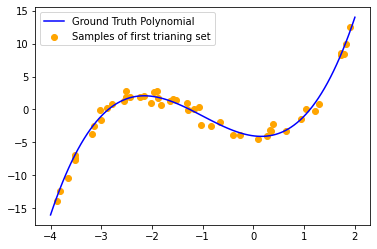

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(33)
# We have 20 training sets with 50 samples in each set
x_samples = np.load('x_samples.npy')    # shape: [20, 50, 1]
y_samples = np.load('y_samples.npy')    # shape: [20, 50, 1]


# we load our plot data (shape: [20, 1])
x_plt = np.load('x_plt.npy')
y_plt = np.load('y_plt.npy')

# let's plot our data (for the training data we just use the first training set)
plt.plot(x_plt, y_plt, c="blue", label="Ground Truth Polynomial")
plt.scatter(x_samples[0, :, :], y_samples[0, :, :], c="orange", label="Samples of first trianing set")
plt.legend()


### Utility Functions for Plotting
Before we start, we define some functions here which we will make use of. You do not need to implement anything in here.

In [10]:
def plot(mse_val: np.ndarray, mse_train:np.ndarray, x_axis, m_star_idx:int, x_plt:np.ndarray, y_plt: np.ndarray,
        x_samples:np.ndarray, y_samples:np.ndarray, model_best, model_predict_func:callable):
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plot_error_curves(mse_val, mse_train, x_axis, m_star_idx)
    plt.subplot(122)
    plot_best_model(x_plt, y_plt, x_samples, y_samples, model_best, model_predict_func)

In [11]:
def plot_error_curves(MSE_val: np.ndarray, MSE_train:np.ndarray, x_axis, m_star_idx: int):
    plt.yscale('log')
    plt.plot(x_axis, np.mean(MSE_val, axis=0), color='blue', alpha=1, label="mean MSE validation")
    plt.plot(x_axis, np.mean(MSE_train, axis=0), color='orange', alpha=1, label="mean MSE train")
    plt.plot(x_axis[m_star_idx], np.min(np.mean(MSE_val, axis=0)), "x", label='best model')
    plt.xticks(x_axis)
    plt.xlabel("model order")
    plt.ylabel("MSE")
    plt.legend()
    
def plot_best_model(x_plt: np.ndarray, y_plt: np.ndarray, x_samples: np.ndarray, y_samples:np.ndarray, 
                    model_best, model_predict_func: callable):
    plt.plot(x_plt, y_plt, color='g', label="Ground truth")
    plt.scatter(x_samples, y_samples, label="Noisy data", color="orange")
    f_hat = model_predict_func(model_best, x_plt)
    plt.plot(x_plt, f_hat, label="Best model")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    
def plot_bars(M, std_mse_val_ho, std_mse_val_cv):
    models = np.arange(1, M+1)
    fig = plt.figure("Comparison of the Standard Deviations of mse's")
    ax1 = fig.add_subplot(111)
    ax1.bar(models, std_mse_val_ho, yerr=np.zeros(std_mse_val_ho.shape), align='center', alpha=0.5, ecolor='black', 
               color='red', capsize=None)
    ax1.bar(models, std_mse_val_cv, yerr=np.zeros(std_mse_val_cv.shape), align='center', alpha=0.5, ecolor='black', 
               color='blue', capsize=None)
    ax1.set_xticks(models)
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Standard Deviation')
    ax1.set_yscale('log')
    ax1.set_xticklabels(models)
    ax1.set_title('Standard Deviations for HO (red) and CV (blue)')
    ax1.yaxis.grid(True)
    plt.legend(['HO', 'CV'])

### 3.1) Hold-Out Method (4 Points)
We will implement the hold-out method in this section. Please see below and fill out the missing code snippets. <br>
Make sure that you follow the instructions written in the comments. Otherwise the code will not run.

In [12]:
def hold_out_method(data_in: np.ndarray, data_out: np.ndarray, split_coeff: float)->Tuple[dict, dict]:
    """
    Splits the data into a training data set and a validation data set. 
    :param data_in: the input data which we want to split, shape: [n_data x indim_data] 
    :param data_out: the output data which we want to split, shape: [n_data x outdim_data]
    Note: each data point i in data_in and data_out is considered as a training/validation sample -> (x_i, y_i)
    :param split_coeff: a value between [0, 1], which determines the index to split data into test and validation set
                        according to: split_idx = int(n_data*split_coeff)
    :return: Returns a tuple of 2 dictionaries: the first element in the tuple is the training data set dictionary
             containing the input data marked with key 'x' and the output data marked with key 'y'.
             The second element in the tuple is the validation data set dictionary containing the input data 
             marked with key 'x' and the output data marked with key 'y'.
    """
    n_data = data_in.shape[0]

    # we use a dictionary to store the training and validation data. 
    train_data = {}
    val_data = {}

    # calculate split index as given above
    split_idx = int(n_data * split_coeff)
    
    # Please use 'x' as a key for the input data and 'y' as a key for the output data in the dictionaries
    # for the training data and validation data
    train_data['x'], val_data['x'] = np.split(data_in, [split_idx])
    train_data['y'], val_data['y'] = np.split(data_out, [split_idx])
    
    return train_data, val_data

### Evaluate Hold-Out (HO) on Regression
This function will automatically call the functions you have implemented. It will make use of the Hold-out method
on the 20 different data sets we have loaded at the beginning. It will return the standard deviation of the 
mean squarred errors of the 20 data sets of each different model it is tested on. You do not need to implement anything here.

In [13]:
def eval_ho_method(M: int, split_coeff: float, fit_func:callable, predict_func: callable):
    """
    :param M: Model complexity param: for polynomial regression model order, for kNNR: number of neighbors
    :param split_coeff:a value between [0, 1], which determines the index to split data into test and validation set
                     according to: split_idx = int(n_data*split_coeff)
    :param fit_func: callable function which will fit your model
    :param predict_func: callable function which will make predictions with your model
    """
    n_repetitions = 20 # we have 20 different data sets, we want to perform HO on....
    models = np.arange(1, M+1)
    mse_train_ho = np.zeros((n_repetitions, M))
    mse_val_ho = np.zeros((n_repetitions, M))
    
    for rep in range(n_repetitions):
        c_x_samples = x_samples[rep, :, :]    # extract the current data set 
        c_y_samples = y_samples[rep, :, :]    # extract the current data set
        train_data, val_data = hold_out_method(c_x_samples, c_y_samples, split_coeff)
        
        for i, m in enumerate(models):
            # 2: Train on training data to obtain \hat{f}_{D_T}(x)
            p = fit_func(train_data['x'], train_data['y'], m)
            f_hat_D_T = predict_func(p, val_data['x'])
            
            # 3: Evaluate resulting estimators on validation data
            mse_val_ho[rep, i] = np.mean((f_hat_D_T - val_data['y'])**2)
            
            # MSE on training set for comparison
            y_train = predict_func(p, train_data['x'])
            mse_train_ho[rep, i] = np.mean((y_train - train_data['y'])**2)
            
            # log parameters of best model order
            if i == 0:
                p_best_ho = p
            else:
                if mse_val_ho[rep, i] <= np.min(mse_val_ho[rep, :i].reshape(-1)):
                    p_best_ho = p
                    
    # mean over all repetitions
    mean_mse_train_ho = np.mean(mse_train_ho, axis=0)
    mean_mse_val_ho = np.mean(mse_val_ho, axis=0)

    std_mse_train_ho = np.std(mse_train_ho, axis=0)
    std_mse_val_ho = np.std(mse_val_ho, axis=0)
    
    # 4: Pick model with best validation loss
    m_star_idx_ho = np.argmin(mean_mse_val_ho) 
    m_star_ho = models[m_star_idx_ho]
    print("Best model complexity for Hold out: {}".format(m_star_ho))
    
    train_data, val_data = hold_out_method(x_samples[0, :, :], y_samples[0,:, :], split_coeff)
    p_best_ho = fit_func(train_data['x'], train_data['y'], m_star_ho)
    
    # use only the first data set for better readability
    plot(mse_val_ho, mse_train_ho, models, m_star_idx_ho, x_plt, y_plt,
        x_samples[0, :, :], y_samples[0, :, :], p_best_ho, predict_func)
    return std_mse_val_ho

### 3.2) K-Fold-Cross Validation Method (4Points)
We will implement the k-fold-cross validation method in this section. Please see below and fill out the missing code snippets. <br>
Make sure that you follow the instructions written in the comments. Otherwise the code will not run. <br> <br>
Please note that the function expects a callable 'fit' and a callable 'predict_func'. You will give different functions to this argument depending on the regression algorithm we consider. All of them have in common that the 'fit' function will return a model, whereas the 'predict_func' function will return a numpy array filled with predictions to the input data. <br>
Please also have a look on the comments. You can also see in the function 'eval_cv_method' on how to use the 
'fit' and 'predict_func' functions.


In [14]:
def k_fold_cross_validation(data_in: np.ndarray, data_out: np.ndarray, m: int, k: int, fit: callable, 
                            predict_func: callable)->Tuple[np.ndarray, np.ndarray, float, float]:
    """
    This function will split the data into a training set and a validation set and will shift the splitted data
    k times and train k different models. It will return the mean squarred error of the training and the validation
    data sets, based on the splits.
    :param data_in: the input data which we want to split, shape: [N indim_data] 
    :param data_out: the output data which we want to split, shape: [N x outdim_data]
    :param m: model parameter (e.g. polynomial degree, or number of nearest neighbors, ...). We will use this 
              variable to call the 'fit' function of your chosen model. Please see the function in the section
              'Evaluation and Fit Functions'.
              m is e.g. the degree of a polynomial
              m is e.g. the parameter k for kNN Regression 
    :param k: number of partitions of the data set (not to be confused with k in kNN)
    :param fit: callable function which will fit your model to the training data you provide -> expects 
                train_in (np.ndarray), train_out (np.ndarray), m (model parameter(s))  
                (e.g. model order in polynomial regression), returns model params
    :param predict_func: callable function which will use your model to do predictions on the input data 
                         you provide -> expects model params (-> m) and data_in (np.ndarray)
    :return mse_train: np.ndarray containg the mean squarred errors for each training data in each split k shape [k]
    :return mse_val: np.ndarray containing the mean squarred errors for the validation data in each split, shape[k]
    """
    n_data = data_in.shape[0]
    if k > n_data:
        k = n_data
    
    # number of validation data
    n_val_data = n_data//k   # e.g.: 15//2 = 7 
    ind = np.arange(0, n_data)
    mse_train = np.zeros(k)
    mse_val = np.zeros(k)


    
    for i in range(k):
        # 1: Split into 2 data sets

        # calculate validation indices
        val_idx = ind[n_val_data * i:n_val_data * i + n_val_data]
        # every other element is training element
        train_idx = np.setdiff1d(ind,val_idx)

        # 2: get the training and validation data set
        train_data = {}
        val_data = {}

        # select elements using masked indices
        train_data['x'], val_data['x'] = data_in[train_idx], data_in[val_idx]
        train_data['y'], val_data['y'] = data_out[train_idx], data_out[val_idx]
        
        # 3: fit your model on training data
        # Use here the 'fit' function. Expects (train_in:np.ndarray, train_out: np.ndarray, m)
        p = fit(train_data['x'], train_data['y'], m)
        
        # 4: evaluate your model on training set and validation set
        # Use here the 'predict_func' function. Expects (model you have fitted, data you want to make predictions). 
        f_hat_train = predict_func(p, train_data['x'])
        f_hat_val = predict_func(p, val_data['x'])

        # 5: assign performance: Calculate the mean squarred error for the training and validation set and
        # write the result into the mse_train and mse_val arrays respectively
        mse_train[i] = np.mean((f_hat_train - train_data['y'])**2)
        mse_val[i] = np.mean((f_hat_val - val_data['y'])**2)


    return mse_train, mse_val

### Evaluate K-Fold-Cross Validation (CV) on Regression
This function will automatically call the functions you have implemented. It will make use of the Cross Validation
method on the 20 different data sets we have loaded at the beginning. It will return the standard deviation 
of the mean squarred errors of the 20 data sets of each different model it is tested on.

In [15]:
def eval_cv_method(M: int, k: int, fit_func:callable, predict_func: callable):
    """
    :param M: Model complexity param: for polynomial regression model order, for kNNR: k number of neighbors
    :param k: number of partitions
    :param fit_func: callable function which will fit your model
    :param predict_func: callable function which will use your model to perform predictions on data
    """
    n_repetitions = 20 # we have 20 different data sets, we want to perform CV on....
    models = np.arange(1, M+1) 
    
    mse_train_cv = np.zeros((n_repetitions, M))
    mse_val_cv = np.zeros((n_repetitions, M))
    
    for rep in range(n_repetitions):
        c_x_samples = x_samples[rep, :, :]    # extract the current data set
        c_y_samples = y_samples[rep, :, :]    # extract the current data set
        
        for i, m in enumerate(models):
            mse_train, mse_val = k_fold_cross_validation(c_x_samples, c_y_samples, m, k, fit_func, predict_func)
            mse_val_cv[rep, i] = np.mean(mse_val)
            mse_train_cv[rep, i] = np.mean(mse_train)
            
    mean_mse_val_cv = np.mean(mse_val_cv, axis=0)
    mean_mse_train_cv = np.mean(mse_train_cv, axis=0)
    std_mse_val_cv = np.std(mse_val_cv, axis=0)    # calculates the standard deviation of the mse's over the 20 data sets
    std_mse_train_cv = np.std(mse_train_cv, axis=0)# calculates the standard deviation of the mse's over the 20 data sets

    m_star_idx_cv = np.argmin(mean_mse_val_cv)
    m_star_cv = models[m_star_idx_cv]
    print("Best model complexity for Cross Validation:", m_star_cv)
    
    # use only the first data set for better readability
    p_best_cv = fit_func(x_samples[0,: ,:], y_samples[0, :, :], m_star_cv)
    
    plot(mse_val_cv, mse_train_cv, models, m_star_idx_cv, x_plt, y_plt,
        x_samples[0, :, :], y_samples[0, :, :], p_best_cv, predict_func)
    
    return std_mse_val_cv

### 3.3) KNN Regression
We will apply Hold-out and K-Fold-Cross Validation on the regression problem using kNN Regression. In the following we provide a fit and a evaluate function for kNN, which will be directly used from the functions for hold-out and cross validation (as a callable). <br><br>
Note that you will not be able to execute kNN Regression, if you haven't programmed the 'get_k_nearest' function from section 2).

In [16]:
def fit_knn_regressor(train_in: np.ndarray, train_out:np.ndarray, k: int)->dict:
    """
    This function will fit a knn model to the data. In fact, it will compactly represent the data provided.
    I.e. it will store the training in- and output data together with the number of k neighbors in a dictionary.
    :param train_in: the training input data, shape [N x input dim]
    :param train_out: the training output data, shape [N x output dim]
    :param k: the parameter how many nearest neighbors to choose.
    :return: returns a dictionary containgin all the information:
             The key 'x' marks the training input data (shape [N x input dim]).
             The key 'y' marks the training output data (shape [N x output dimension]).
             The key 'k' marks the parameter for k-nearest neighbors to be considered. 
    """
    model = {'x': train_in, 'y': train_out, 'k': k}
    return model

In [17]:
def predict_knn_regressor(model, data_in: np.ndarray)->np.ndarray:
    """
    This function will perform predictions using a knn regression model given the input data. 
    Note that knn is a lazy model and requires to store
    all the training data (see dictionary 'model').
    :param model: dictionary containing the train data and the k parameter for k nearest neighbors. 
                  The key 'x' marks the training input data (shape [N x input dim]).
                  The key 'y' marks the training output data (shape [N x output dimension]).
                  The key 'k' marks the parameter for k-nearest neighbors to be considered.
    :param data_in: the data we want to perform predictions (shape [N x input dimension])
    :return prediction based on k nearest neighbors (mean of the k - neares neighbors) (shape[N x output dimension])
    """
    if len(data_in.shape) == 1:
        data_in = np.reshape(data_in, (-1, 1))
    train_data_in = model['x']
    train_data_out = model['y']
    k = model['k']
    if len(train_data_in) == 1:
        train_data_in = np.reshape(train_data_in, (-1, 1))
    predictions = np.zeros((data_in.shape[0], train_data_out.shape[1]))
    for i in range(data_in.shape[0]):
        c_data = data_in[i, :]
        _, nearest_y = get_k_nearest(k, c_data, train_data_in, train_data_out)   
        # we take the mean of the nearest samples to perform predictions
        predictions[i, :] = np.mean(nearest_y, axis=0)    
    return predictions

### 3.3.1) Applying Hold-Out (HO) and Cross-Validation (CV)  to KNN Regression 

We apply kNN Regression on our data set, where we vary the number of neighbors K (here denoted as variable M_knn). We apply Hold-out and Cross Validation on the 20 data sets and calculate the mean of the mean squarred error for each model, for both the Hold out method as well as the Cross Validation method. <br>
We furthermore plot the standard deviation of the mean squarred errors for each model based on the 20 data sets. We compare the standard deviations resulting from the Hold out method and the Cross Validation method. 

In [18]:
M_knn = 20     # Number of Neighbors K 
split_coeff = 0.8 # between 0,1: how many samples to split in Hold-out
k = 15        # number of splits for Cross Validation

Best model complexity for Hold out: 2
Best model complexity for Cross Validation: 2


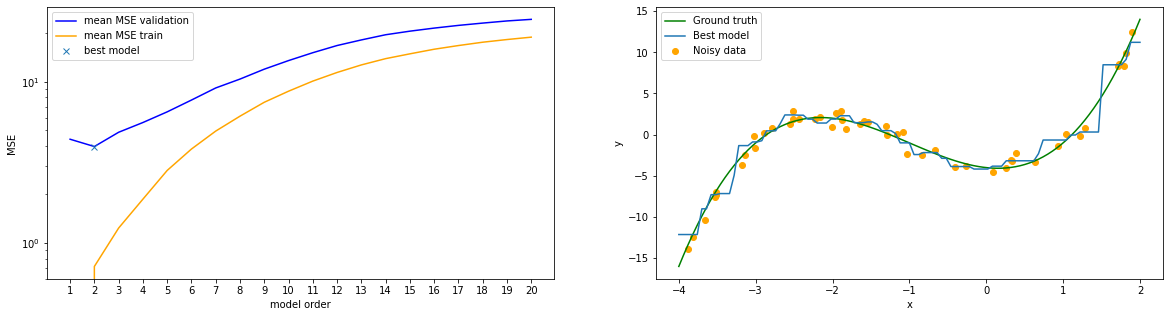

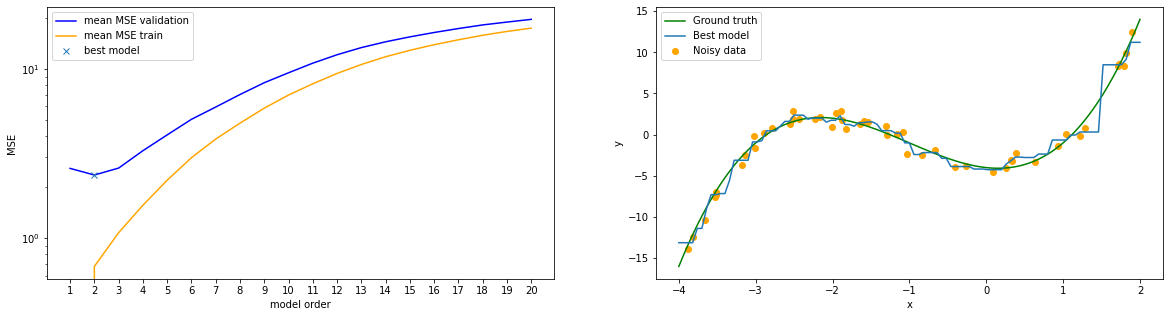

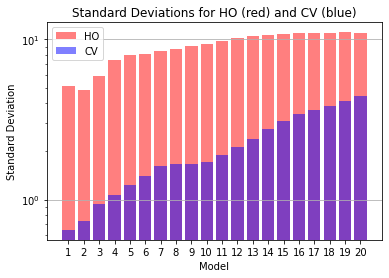

In [19]:
# Hold Out
std_mse_val_ho_knn = eval_ho_method(M=M_knn, split_coeff=split_coeff, fit_func=fit_knn_regressor, 
               predict_func=predict_knn_regressor)

# Cross Validation
std_mse_val_cv_knn = eval_cv_method(M=M_knn, k=k, fit_func=fit_knn_regressor, 
                                    predict_func=predict_knn_regressor)

# Comparing the standard deviations
plot_bars(M_knn, std_mse_val_ho_knn, std_mse_val_cv_knn)


The first two rows in  the cell above showcase the errorplots and the best model's prediction for Hold out (first row) and Cross Validation(second row) respectively. <br>
The last row in the above cell shows each model's standard deviation on the mean squarred error evaluated on the 20 different data sets. The red bars are the standard deviation for Hold-out and the blue bars are the standard deviations for Cross Validation.


### 3.4) Forests
We will apply Hold-out and K-Fold-Cross Validation on the regression problem using regression with forests. In the following we provide a fit and a evaluate function for forests, which will be directly used from the functions for hold-out and cross validation (as a callable). <br>
Please note that we have two different functions for fitting a forest model. In 'fit_forest_fixed_n_trees' we investigate the behavior of the algorithm by fixing the number of trees to 1 and varying the number of sample per leaf. <br>
In 'fit_forest_fixed_n_samples_leaf' we fix the number of samples per leaf to 1 and investigate the behavior of the algorithm by varying the number of trees. <br>
The evaluation function can be used for both models.

In [20]:
def fit_forest_fixed_n_trees(train_in: np.ndarray, train_out:np.ndarray, min_samples_leaf: int):
    """
    This function will fit a forest model based on a fixed number of trees (can not be change when using this 
    function, is set globally)
    :param train_in: the training input data, shape [N x input dim]
    :param train_out: the training output data, shape [N x output dim]
    :param min_samples_leaf: the number of samples per leaf to be used 
    """
    model = RandomForestRegressor(n_estimators=1, min_samples_leaf=min_samples_leaf)
    model.fit(train_in, train_out)
    return model

In [21]:
def fit_forest_fixed_n_samples_leaf(train_in: np.ndarray, train_out:np.ndarray, n_trees: int):
    """
    This function will fit a forest model based on a fixed number of sample per leaf (can not be change when 
    using this function, is set globally)
    :param train_in: the training input data, shape [N x input dim]
    :param train_out: the training output data, shape [N x output dim]
    :param n_trees: the number of trees in the forest 
    """
    model = RandomForestRegressor(n_estimators=n_trees, min_samples_leaf=1)
    model.fit(train_in, train_out)
    return model

In [22]:
def predict_forest(model, data_in: np.ndarray)->np.ndarray:
    """
    This function will perform predictions using a forest regression model on the input data. 
    :param model: the forest model from scikit learn (fitted before)
    :param data_in: :param data_in: the data we want to perform predictions (shape [N x input dimension])
    :return prediction based on chosen minimum samples per leaf (shape[N x output dimension]
    """
    y = model.predict(data_in)
    if len(y.shape) == 1:
        y = y.reshape((-1, 1))
    return y

### 3.4.1) Applying Hold-Out (HO) and Cross-Validation (CV)  to Forests (Fixed number of Trees)

We apply Forest Regression with fixed number of trees to 1 on our data set, where we vary the number of samples per leaf(here denoted as variable min_samples_leaf). We apply Hold-out and Cross Validation on the 20 data sets and calculate the mean of the mean squarred error for each model, for both the Hold out method as well as the Cross Validation method. <br>
We furthermore plot the standard deviation of the mean squarred errors for each model based on the 20 data sets. We compare the standard deviations resulting from the Hold out method and the Cross Validation method. 

In [23]:
min_samples_leaf = 10       # used when fixed number of trees and we want to evaluate number of samples per leaf
split_coeff = 0.8           # between 0,1: how many samples to split in Hold-out
k = 15                      # number of splits for Cross Validation

Best model complexity for Hold out: 1
Best model complexity for Cross Validation: 1


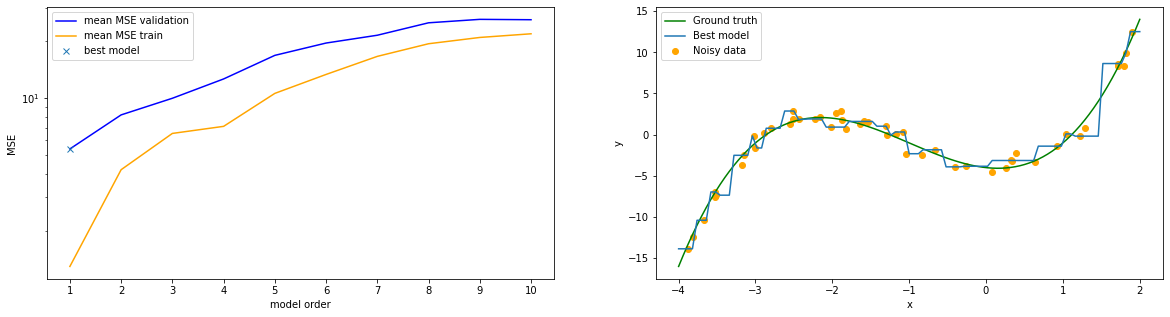

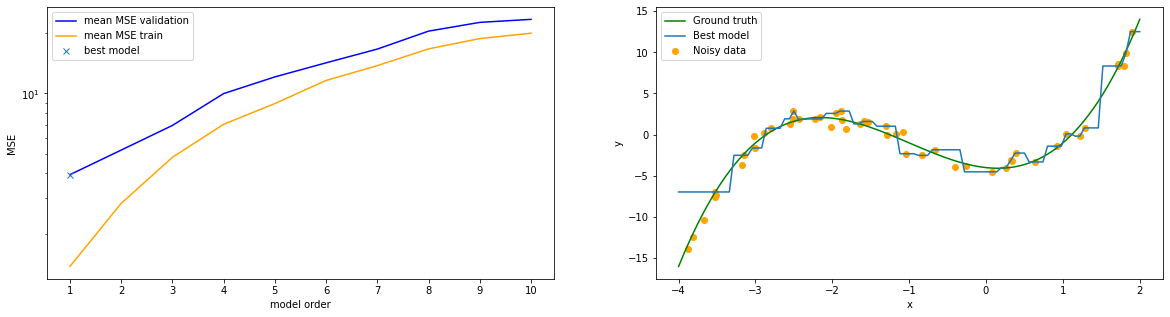

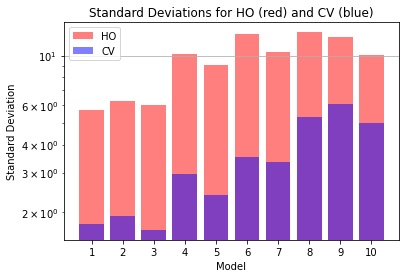

In [24]:
#Hold-Out
std_mse_val_ho_forest_fixed_n_trees = eval_ho_method(M=min_samples_leaf, split_coeff=split_coeff, 
                                                     fit_func=fit_forest_fixed_n_trees, 
                                                     predict_func=predict_forest)
# Cross Validation 
std_mse_val_cv_forest_fixed_n_trees = eval_cv_method(M=min_samples_leaf, k=k, fit_func=fit_forest_fixed_n_trees, 
                                    predict_func=predict_forest)

# Comparing the standard deviations
plot_bars(min_samples_leaf, std_mse_val_ho_forest_fixed_n_trees, std_mse_val_cv_forest_fixed_n_trees)

The first two rows in  the cell above showcase the errorplots and the best model's prediction for Hold out (first row) and Cross Validation(second row) respectively. <br>
The last row in the above cell shows each model's standard deviation on the mean squarred error evaluated on the 20 different data sets. The red bars are the standard deviation for Hold-out and the blue bars are the standard deviations for Cross Validation.


### 3.4.2) Applying Hold-Out (HO) and Cross-Validation (CV)  to Forests (Fixed number of Samples per Leaf) 
We apply Forest Regression with fixed number of samples per leaf to 1 on our data set, where we vary the number of trees (here denoted as variable n_trees). We apply Hold-out and Cross Validation on the 20 data sets and calculate the mean of the mean squarred error for each model, for both the Hold out method as well as the Cross Validation method. <br>
We furthermore plot the standard deviation of the mean squarred errors for each model based on the 20 data sets. We compare the standard deviations resulting from the Hold out method and the Cross Validation method. 

In [25]:
n_trees = 20       # used when fixed number of trees and we want to evaluate number of samples per leaf
split_coeff = 0.8           # between 0,1: how many samples to split in Hold-out
k = 15                      # number of splits for Cross Validation

Best model complexity for Hold out: 13
Best model complexity for Cross Validation: 20


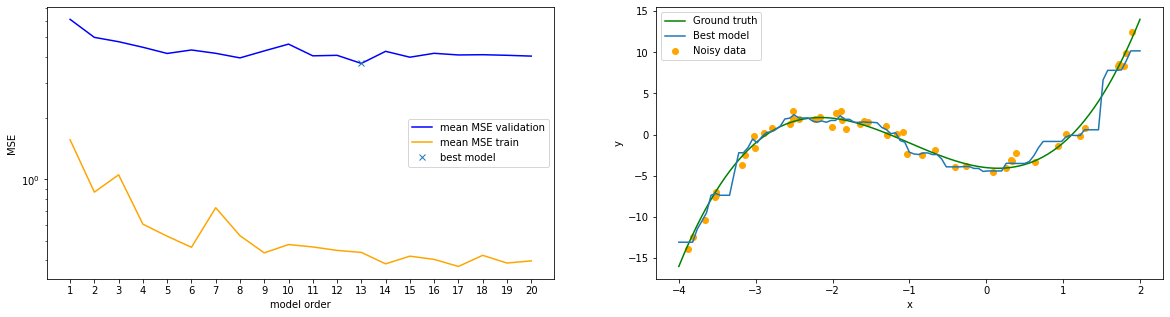

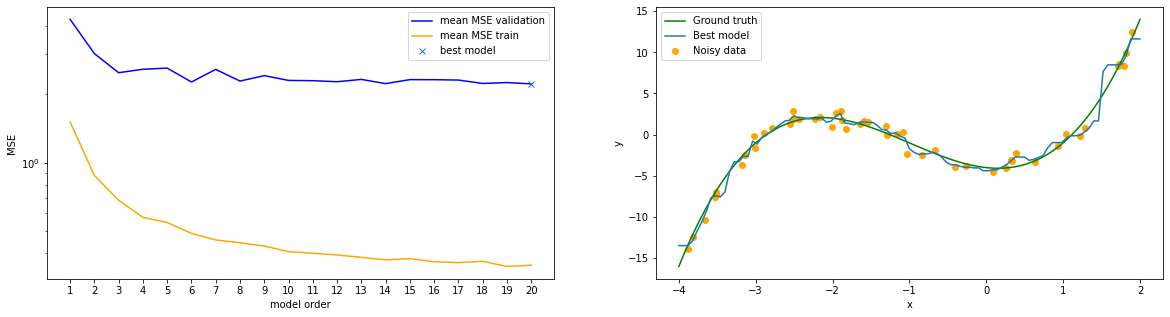

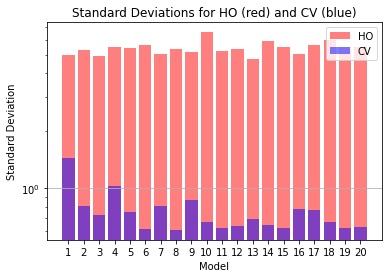

In [26]:
# Hold out
std_mse_val_ho_forest_fixed_n_samples = eval_ho_method(M=n_trees, split_coeff=split_coeff, 
                                                       fit_func=fit_forest_fixed_n_samples_leaf,  
                                                       predict_func=predict_forest)
# Cross Validation
std_mse_val_cv_forest_fixed_n_samples = eval_cv_method(M=n_trees, k=k, 
                                                       fit_func=fit_forest_fixed_n_samples_leaf, 
                                                       predict_func=predict_forest)


# Comparing the standard deviations
plot_bars(n_trees, std_mse_val_ho_forest_fixed_n_samples, std_mse_val_cv_forest_fixed_n_samples)


The first two rows in  the cell above showcase the errorplots and the best model's prediction for Hold out (first row) and Cross Validation(second row) respectively. <br>
The last row in the above cell shows each model's standard deviation on the mean squarred error evaluated on the 20 different data sets. The red bars are the standard deviation for Hold-out and the blue bars are the standard deviations for Cross Validation.


### 3.5) Comparisons

#### 3.5.1) (1 Point)
Comparing the error plots from section 3.4.2) to the error plots from 3.3.1) and 3.4.1) we observe that the validation error does not increase with the number of trees. Give an intution for this observation. <br><br>

- As a random forest is a combination of several trees, the validation error is generally speaking more stable. By fixing the number of samples per leaf, one can make sure, that the average for each leaf is calculated from a minimum amount of observations. Which then leads to a more stable validation error.

#### 3.5.2) (1 Point)
Compare the standard deviation plots from the last three sections. What is the main difference between Hold-out method and Cross Validation you can observe for all three Standard Deviation plots? Explain the reason for the observed behavior. <br> <br>

- Generally speaking the standard deviation for the Cross Validation method is much smaller, as compared to the hold-out-method the *entire* dataset get's used for training by "rotating" the $k$-fold, that is used for validation. Therefore, more data for training the models is available and results are more stable. Considering that our datasets are rather small, this is vital.
